In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_arxiv import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.graph_sage import StructuralOmegaGraphSageCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/04-1-structural_graphsage_dotmlp_gamma_function.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [5]:
dataset = load_dataset()

In [6]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [7]:
data = prepare_adjencency(data)

## Training

In [8]:
for run in range(5):
    for n_layers_graph_sage in range(1, 4):
        omega = StructuralOmegaGraphSageCosSim(
            device,
            n_layers_graph_sage=n_layers_graph_sage,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y,
                    data.adj_t)

## Results

### For a Layer Number

In [9]:
n_layers_graph_sage = 1

In [10]:
metrics = StructuralOmegaGraphSageCosSim.read_metrics(
    n_layers_graph_sage=n_layers_graph_sage)
print(metrics.shape)
metrics.head()

(255, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.624841,0.658962,0.664581,0.586509,0.571247,0.563037
1,0,100,0.535221,0.561342,0.579264,0.788767,0.777307,0.748823
2,0,200,0.515649,0.544557,0.565283,0.800765,0.785517,0.757487
3,0,300,0.500886,0.533084,0.556806,0.810152,0.791526,0.762570
4,0,400,0.491770,0.526345,0.551813,0.815179,0.794722,0.765838


### Sumarize metrics per epoch

In [11]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [12]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [13]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.624455,0.000302,0.658200,0.000592,0.663816,0.000626,0.588351,0.003776,0.573258,0.004089,0.564940,0.004033
100,0.535864,0.000554,0.562283,0.001086,0.580147,0.001359,0.787916,0.000730,0.776196,0.001407,0.747597,0.002243
200,0.518914,0.005427,0.549394,0.006875,0.569964,0.006554,0.796693,0.007181,0.779690,0.008103,0.751278,0.007932
300,0.501921,0.001316,0.534156,0.001583,0.557923,0.001807,0.809254,0.001107,0.790532,0.001456,0.761315,0.002317
400,0.496373,0.008635,0.533060,0.013213,0.558052,0.013299,0.810951,0.007534,0.789073,0.010110,0.759678,0.012280


In [14]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
3700,0.458211,0.000644,0.514344,0.000655,0.548890,0.001115,0.834448,0.000407,0.803020,0.000371,0.774037,0.000502
4600,0.458200,0.001427,0.514738,0.001239,0.549209,0.001911,0.834451,0.000937,0.802862,0.000733,0.774034,0.000808
4700,0.457482,0.000499,0.515104,0.000955,0.550305,0.001633,0.835061,0.000386,0.802725,0.000510,0.773392,0.000901
2800,0.460833,0.003694,0.514303,0.001149,0.548054,0.002030,0.832616,0.002648,0.802664,0.000778,0.773738,0.001154
3900,0.457582,0.000201,0.514991,0.000110,0.549988,0.000254,0.834886,0.000157,0.802620,0.000085,0.773442,0.000203


/tmp/ipykernel_17761/4081711120.py:29: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_17761/4081711120.py:77: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



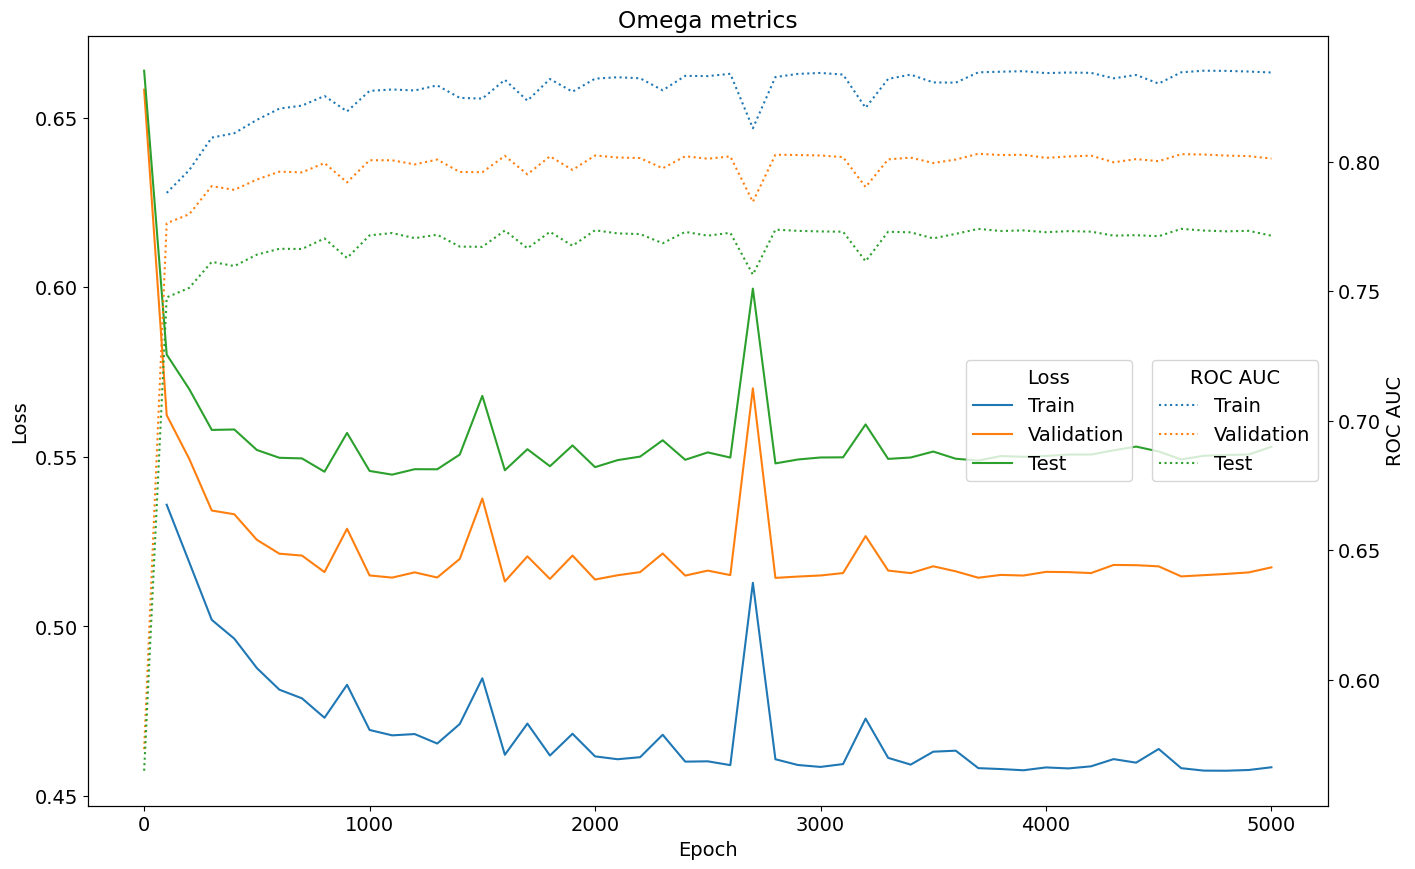

In [16]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

# ax1.errorbar(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.plot(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    # yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.plot(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    # yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.plot(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    # yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

# ax2.errorbar(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.plot(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    # yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.plot(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    # yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.plot(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    # yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/structural_omega_graphsage_cossim_training_metrics_{n_layers_graph_sage}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [17]:
n_layers_list = range(1, 4)

In [18]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(n_layers_graph_sage=n_layers_graph_sage)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_graph_sage] = auc_val
    mean_loss_val_dict[n_layers_graph_sage] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_graph_sage] = auc_val
    std_loss_val_dict[n_layers_graph_sage] = loss_val

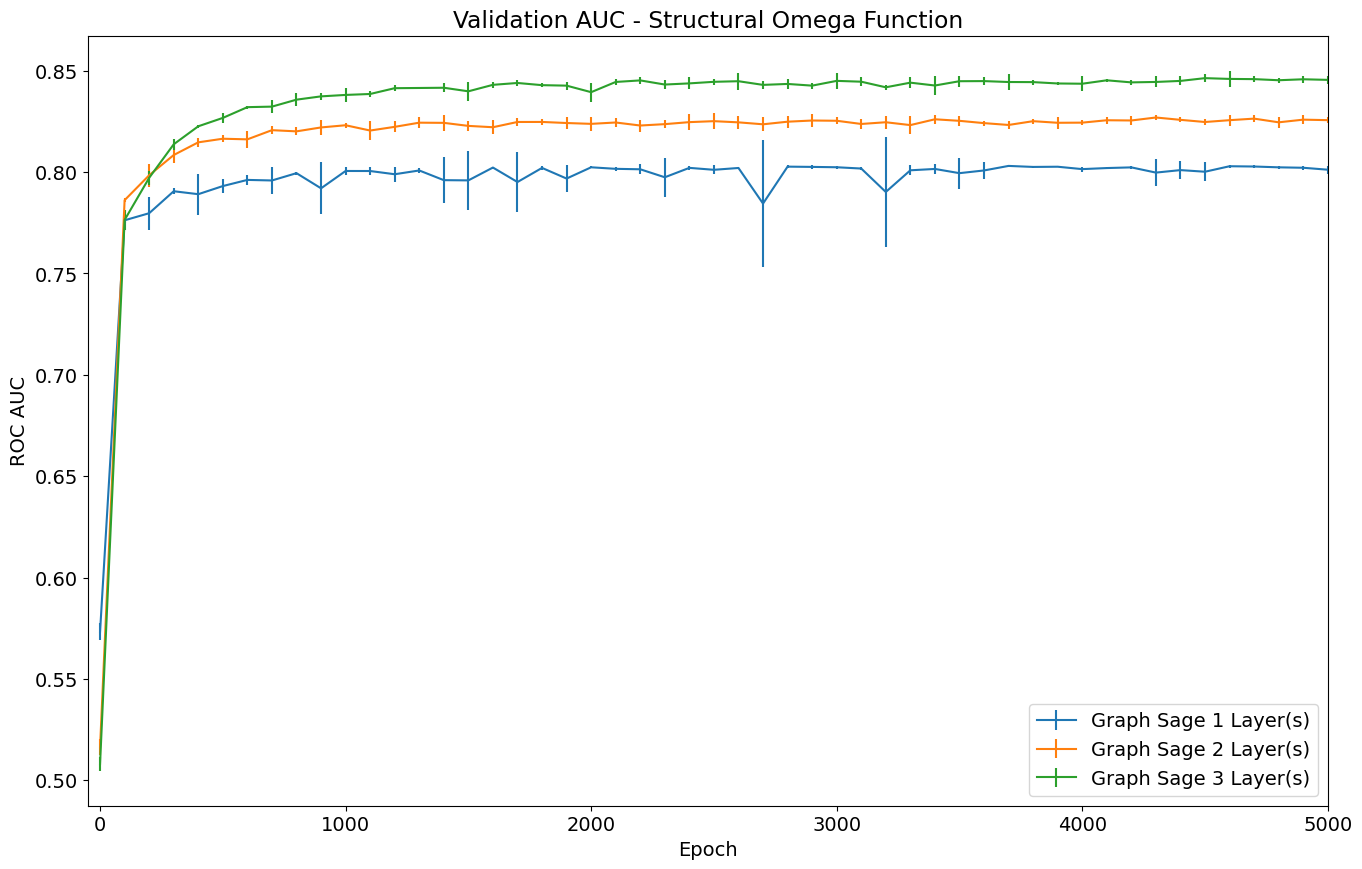

In [24]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)')

ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [7]:
n_layers_list = range(1, 4)

In [8]:
full_metrics = []
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(
        n_layers_graph_sage=n_layers_graph_sage)
    metrics['n_layers_graph_sage'] = n_layers_graph_sage
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [9]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run                       4.000000
epoch                  4600.000000
loss_train                0.382392
loss_val                  0.465065
loss_test                 0.515976
auc_train                 0.889903
auc_val                   0.851588
auc_test                  0.818473
n_layers_graph_sage       3.000000
Name: 250, dtype: float64

In [10]:
best_model_metrics.to_json('models/structural_omega_grapn_sage_cossim/best_model_info.json')

### Load data

In [11]:
dataset = load_dataset()
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)
data = prepare_adjencency(data)

### Load model

In [13]:
omega = StructuralOmegaGraphSageCosSim.load_model(
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device=device,
    n_layers_graph_sage=int(best_model_metrics['n_layers_graph_sage']))

### Score model

In [ ]:
preds = omega.forward(all_edges, data.adj_t).to('cpu').detach().numpy()
preds[:5]

array([[0.64966935],
       [0.78425   ],
       [0.78780687],
       [0.78720075],
       [0.7848394 ]], dtype=float32)

In [ ]:
theta = gamma.is_same_class(all_edges, data.y).to('cpu').detach().numpy()

In [ ]:
roc_auc_score(theta, preds)

0.6808699849370341

In [ ]:
theta.mean()

0.6542197738985782

### Save output

In [ ]:
cpu_edges = all_edges.to('cpu').numpy()
edges_gamma_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'gamma_pred': preds[:,0]
})
print(edges_gamma_df.shape)
edges_gamma_df.head()

(2315598, 3)


,source,target,gamma_pred
0,411,0,0.649669
1,640,0,0.784250
2,1162,0,0.787807
3,1897,0,0.787201
4,3396,0,0.784839


In [ ]:
edges_gamma_df.to_csv('data/gamma_graph_sage/01-1_gamma_scored_edges.csv', index=False)

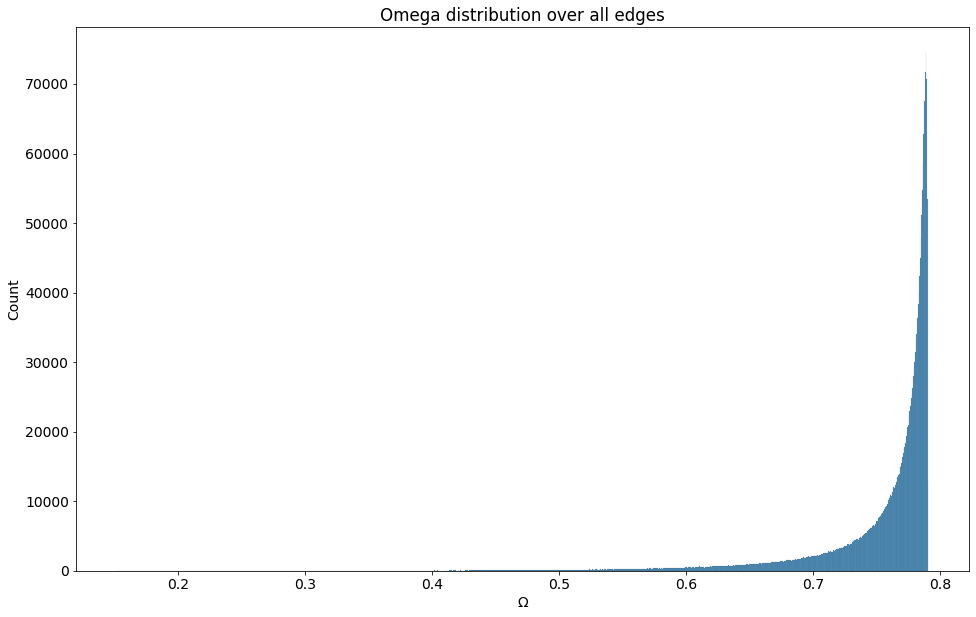

In [ ]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_gamma_df['gamma_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
plt.savefig('reports/images/best_omega_distribution.png')